In [1]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/rBergomiTrainSet.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

In [2]:
yy = yy.reshape(-1,8,11)
xx = np.repeat(xx, 8*11,axis=0)

def append_and_expand(a,x,y):
    # use choose and where !
    n = len(x)*len(y)
    a_index = np.arange(len(a))%n
    
    
    x_index = a_index//len(y)
    y_index = a_index%len(y)
    
    x_added = np.choose(x_index,x.reshape(-1,1)).reshape(-1,1)
    y_added = np.choose(y_index,y.reshape(-1,1)).reshape(-1,1)
    
    return np.hstack([a,x_added,y_added])

In [3]:
xx_pointwise=append_and_expand(xx,maturities,strikes)
yy_pointwise = yy.reshape(-1)

xx = xx_pointwise
yy = yy_pointwise.reshape(-1,1)

In [5]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)

scale_y=  StandardScaler()

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,4,-0.1,0.5,2.0,1.5])
lb=np.array([0.01,0.3,-0.95,0.025,0.1,0.5])

def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device is {device}")

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_transform).to(device=device),
                                               torch.from_numpy(y_train_transform).to(device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_transform).to(device=device),
                                              torch.from_numpy(y_test_transform).to(device=device))


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

data_loader = torch.utils.data.DataLoader(train_dataset,batch_size =64,shuffle=True)

device is cuda


In [6]:
import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparas = {'input_dim':6,'hidden_dim':32,'hidden_nums':20,'output_dim':1,'block_layer_nums':2}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=torch.float64)

loss_MSE = nn.MSELoss()
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.0001)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 39.29756704228721
test loss is 38.151167433797696
Batch: 100,train loss is: 0.5843639881753468
test loss is 0.842929599332749
Batch: 200,train loss is: 0.5139097652656766
test loss is 0.5533844549454616
Batch: 300,train loss is: 0.33245057524485067
test loss is 0.39787144608994124
Batch: 400,train loss is: 0.2517176686485404
test loss is 0.30462911331256803
Batch: 500,train loss is: 0.15948836229594548
test loss is 0.24707808222130523
Batch: 600,train loss is: 0.18326424653655704
test loss is 0.2042683893634944
Batch: 700,train loss is: 0.13854767127035805
test loss is 0.17489374900916344
Batch: 800,train loss is: 0.24754608838131598
test loss is 0.15244884814755724
Batch: 900,train loss is: 0.13333990608123086
test loss is 0.13547747333558702
Batch: 1000,train loss is: 0.13805892667338932
test loss is 0.122157739067549
Batch: 1100,train loss is: 0.060020524032344286
test loss is 0.112118524694201

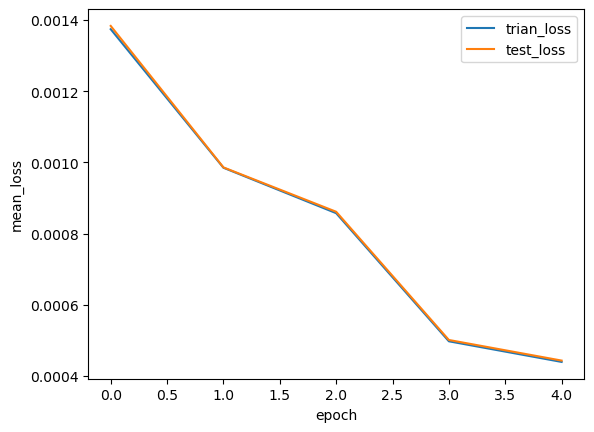

In [7]:
from torch_NN.train import train_model

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,5)

In [8]:
torch.save(model.state_dict(),'../../Data/YU/rflatBergomi_pointwise.pth')